# House M.D.

https://en.wikipedia.org/wiki/House_%28TV_series%29

Transcript data: http://clinic-duty.livejournal.com

Work in progress

In [1]:
%pylab inline

import os
from importlib import reload
import path
import time
import re

import string
from collections import defaultdict
from operator import itemgetter


import textblob
from textblob import TextBlob

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Import local files

In [2]:
# update the search path for modules
main_scripts = os.path.join(os.getcwd(), 'main/')
if main_scripts not in sys.path:
    sys.path.insert(0, main_scripts)

import scraper
import transcript

In [3]:
data_dir = os.path.join(os.getcwd(), 'data')
episode_index_url = 'http://clinic-duty.livejournal.com/tag/episode%20index'

## Load

In [4]:
# if files changed on disk
reload(scraper)
reload(transcript)
None

In [5]:
# get raw html files
all_raw_episodes = scraper.Scraper(data_dir, episode_index_url).get_all_episodes()

1... 2... 3... 4... 5... 6... 7... 8... 

In [6]:
# extract and parse transcripts from html 
all_transcripts = {}
for season, episode_html_mapping in all_raw_episodes.items():
    episode_transcript_mapping = {}
    for episode, html in episode_html_mapping.items():
        episode_transcript_mapping[episode] = transcript.Transcript(season, episode, html)
    all_transcripts[season] = episode_transcript_mapping

## No spoiler!

I haven't seen all the episodes yet :)

In [7]:
last_season = 5
transcripts = {season: all_transcripts[season] for season in range(1, last_season+1)}

In [8]:
all_episode_numbers = [(season_num, episode_num) for season_num, season in transcripts.items() for episode_num in season]

In [9]:
'Looking at {} episodes over {} seasons'.format(len(all_episode_numbers), len(transcripts))

'Looking at 110 episodes over 5 seasons'

## Look at data a bit

In [10]:
speakers = defaultdict(int)
for season in transcripts.values():
    for episode in season.values():
        for dialogue in episode.get_dialogue_lines():
            speakers[dialogue.speaker] += 1
            
sorted([(speaker, line_count) for speaker, line_count in speakers.items()], key=itemgetter(1), reverse=True)[:20]

[('house', 14484),
 ('foreman', 4967),
 ('cameron', 3816),
 ('chase', 3138),
 ('wilson', 3037),
 ('cuddy', 2652),
 ('taub', 1290),
 ('thirteen', 1199),
 ('kutner', 983),
 ('greg house', 963),
 ('stacy', 454),
 ('amber', 287),
 ('james wilson', 224),
 ('eric foreman', 196),
 ('dad', 186),
 ('lisa cuddy', 181),
 ('amber volakis', 178),
 ('chris taub', 175),
 ('mom', 154),
 ('patient', 148)]

TODO: resolve nicknames: "thirteen" === "hadley", "house" === "dr house" === "greg house", ...

## Build characters

In [11]:
class Character:
    
    def __init__(self, lines):
        self.lines = lines
        self.num_lines = len(lines)
        
        lines_by_episode = defaultdict(lambda: defaultdict(list))
        for season_num, episode_num, line in lines:
            lines_by_episode[season_num][episode_num].append(line)
        self.lines_by_episode = lines_by_episode
        
    def get_text_as_one_string(self):
        texts = []
        for _, _, line in self.lines:
            texts.append('  '.join(line.spoken_parts))
        return '\n'.join(texts)

In [12]:
speaker_lines = defaultdict(list)
for season_num, season in transcripts.items():
    for episode_num, transcript in season.items():
        for line in transcript.get_dialogue_lines():
            speaker_lines[line.speaker].append((season_num, episode_num, line))

In [13]:
all_characters = {}
for speaker, lines in speaker_lines.items():
    all_characters[speaker] = Character(lines)

In [14]:
all_characters['house'].lines_by_episode[1][2][:10]

[Line(15, house, ['Close the door. Close the door!'], []),
 Line(17, house, ['She’s knows I’m in here, the clinic, as she commanded; she just doesn’t know I’m alone.'], []),
 Line(19, house, ['I’m off at 4', '00.'], []),
 Line(21, house, ['I go out there, I get assigned a kid with a runny nose. That’s 30 seconds looking at the nose; 25 minutes talking to a worried mom who won’t leave until she sure it’s not meningitis or a tumor.'], []),
 Line(23, house, ['That would be lying.'], []),
 Line(26, house, ['Not the definition of case though.'], []),
 Line(29, house, ['Cameron is answering my mail.'], []),
 Line(31, house, ['Research?'], []),
 Line(37, house, ['So, 4', '03 PM. Dr. House checks out. Please write that down.'], []),
 Line(39, house, ['Sorry, done for the day. There’s plenty of docs here to take care of you.'], [])]

## Play!

In [15]:
main_characters = ['house', 'foreman', 'cameron', 'chase', 'wilson', 'cuddy', 'stacy']

### "You're miserable"

In [16]:
def frequency_of_phrase(phrase, characters):
    for c_name in characters:
        c = all_characters[c_name]
        text = c.get_text_as_one_string()
        num_occ = text.lower().count(phrase)
        print('{} said "{}" {} times'.format(c_name, phrase, num_occ))

In [17]:
frequency_of_phrase('miserable', main_characters)

house said "miserable" 43 times
foreman said "miserable" 8 times
cameron said "miserable" 6 times
chase said "miserable" 4 times
wilson said "miserable" 24 times
cuddy said "miserable" 8 times
stacy said "miserable" 0 times


In [18]:
frequency_of_phrase('screw up', main_characters)  # TODO: regex: screwed up

house said "screw up" 21 times
foreman said "screw up" 1 times
cameron said "screw up" 1 times
chase said "screw up" 9 times
wilson said "screw up" 1 times
cuddy said "screw up" 3 times
stacy said "screw up" 3 times


## Number of lines per character per episode

In [19]:
num_lines = {character: [] for character in main_characters}
xlabels = []
for season_num, episode_num in all_episode_numbers:
    xlabels.append('s{}e{}'.format(season_num, episode_num))
    for character in main_characters:
        lines = all_characters[character].lines_by_episode[season_num][episode_num]
        num_lines[character].append(len(lines))

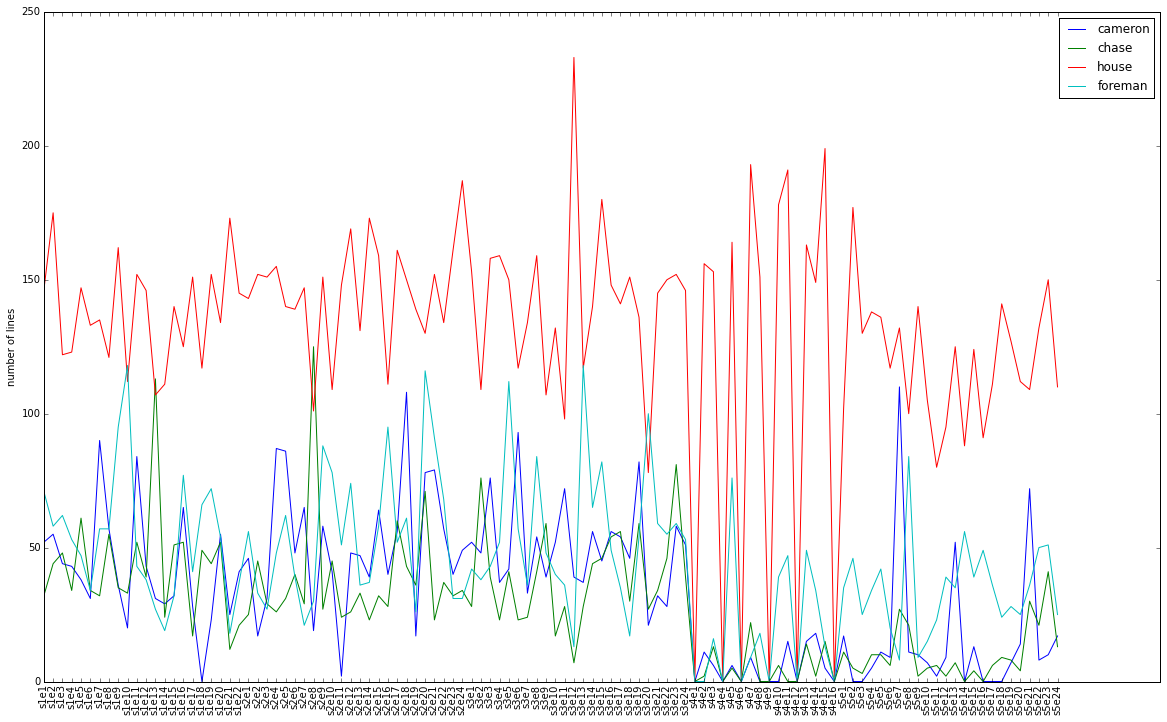

In [20]:
# TODO: normalise by number of lines in the episode?

plt.figure(figsize=(20,12))
for character, nlines in num_lines.items():
    #if character in ('house', 'cuddy', 'wilson', 'stacy'):
    if character in ('house', 'cameron', 'chase', 'foreman'):
        plt.plot(nlines, label=character)
plt.legend(loc='best')
plt.xticks(range(len(all_episode_numbers)), xlabels, rotation='vertical')
plt.ylabel('number of lines')
plt.show()

What are the peaks?

When number of lines for "house" is 0, it's probably because the transcriber used a different nickname, e.g. "dr house"

In [21]:
print('house, high')
print(list(filter(lambda ep_n: ep_n[1] >= 200, list(zip(all_episode_numbers, num_lines['house'])))))
print('house, low')
print(list(filter(lambda ep_n: ep_n[1] <= 100, list(zip(all_episode_numbers, num_lines['house'])))))
print('chase, high')
print(list(filter(lambda ep_n: ep_n[1] >= 100, list(zip(all_episode_numbers, num_lines['chase'])))))
print('chase, low')
print(list(filter(lambda ep_n: ep_n[1] <= 10, list(zip(all_episode_numbers, num_lines['chase'])))))

house, high
[((3, 12), 233)]
house, low
[((3, 11), 98), ((3, 20), 78), ((4, 1), 0), ((4, 4), 0), ((4, 6), 0), ((4, 9), 0), ((4, 12), 0), ((4, 16), 0), ((5, 8), 100), ((5, 11), 80), ((5, 12), 95), ((5, 14), 88), ((5, 16), 91)]
chase, high
[((1, 13), 113), ((2, 8), 125)]
chase, low
[((3, 12), 7), ((4, 1), 0), ((4, 2), 2), ((4, 4), 0), ((4, 5), 5), ((4, 6), 0), ((4, 8), 0), ((4, 9), 0), ((4, 10), 6), ((4, 11), 0), ((4, 12), 0), ((4, 14), 2), ((4, 16), 0), ((5, 2), 5), ((5, 3), 3), ((5, 4), 10), ((5, 5), 10), ((5, 6), 6), ((5, 9), 2), ((5, 10), 5), ((5, 11), 6), ((5, 12), 2), ((5, 13), 7), ((5, 14), 0), ((5, 15), 4), ((5, 16), 0), ((5, 17), 6), ((5, 18), 9), ((5, 19), 8), ((5, 20), 4)]


In [22]:
# TODO: look at the characters one after the other to see the variations

### Evolution of the sentiment in each episode

Look only at the spoken parts because some transcript don't have comments

#### First, look at 1 episode

In [23]:
transcript = all_transcripts[2][5]

In [24]:
sentence = ' '.join(list(transcript.get_dialogue_lines())[75].spoken_parts)
print(sentence)
TextBlob(sentence).sentiment

Well this, this is perfect.


Sentiment(polarity=1.0, subjectivity=1.0)

In [25]:
text = transcript.get_dialogue_as_one_string()

In [26]:
blob = TextBlob(text)
blob.sentiment

Sentiment(polarity=0.06665244873231808, subjectivity=0.49328373724454494)

In [27]:
tokens = blob.tokens
words = blob.words  # no punctuation
sentences = blob.sentences

In [28]:
len(tokens), tokens[20:30]

(6997,
 WordList(['fact', 'that', 'I', 'actually', 'graduated', '.', 'I', 'always', 'knew', 'you']))

In [29]:
len(words), words[20:30]

(5933,
 WordList(['I', 'actually', 'graduated', 'I', 'always', 'knew', 'you', "'d", 'be', 'able']))

In [30]:
len(sentences), sentences[20:25]

(735,
 [Sentence("What?"),
  Sentence("Yeah right, you shocked me."),
  Sentence("With what?"),
  Sentence("I got nothing."),
  Sentence("Yo dude, check it out.")])

In [31]:
words[:200]

WordList(['I', 'ought', 'to', 'have', 'this', 'framed', 'my', 'last', 'bill', 'from', 'Princeton', 'And', 'I', 'thought', 'we', 'were', 'celebrating', 'the', 'fact', 'that', 'I', 'actually', 'graduated', 'I', 'always', 'knew', 'you', "'d", 'be', 'able', 'to', 'graduate', 'what', 'I', 'didn’t', 'know', 'was', 'whether', 'I', 'would', 'be', 'able', 'to', 'pay', 'for', 'it', 'Your', 'mom', 'uh', 'she’d', 'be', 'so', 'proud', 'of', 'you', 'You', 'always', 'say', 'that', 'I’m', 'so', 'proud', 'of', 'you', 'Always', 'was', 'Come', 'on', 'dad', 'you', 'going', 'to', 'cry', 'You', 'want', 'to', 'be', 'embarrassed', 'You', 'got', 'it', 'Look', 'uh', 'don’t', 'party', 'too', 'hard', 'tonight', 'your', 'grandmother', 'wants', 'a', 'picture', 'of', 'you', 'getting', 'that', 'sheepskin', 'and', 'it’d', 'be', 'nice', 'if', 'you', 'didn’t', 'look', 'completely', 'hung-over', 'Ooh', 'no', 'don’t', 'worry', 'I’ve', 'had', 'enough', 'alcohol', 'in', 'the', 'past', 'week', 'to', 'last', 'me', 'another', 

In [32]:
def sliding_window(seq, size=10, step=1, merge=False):
    for i in range(0, len(seq)-size+1, step):
        window = seq[i:i+size]
        if merge:
            yield ' '.join(window)
        else:
            yield window
        
print(list(sliding_window(['0', '1', '2', '3', '4', '5', '6'], 3)))
print(list(sliding_window('abcde', 2, merge=True)))
print(list(sliding_window(range(20), 10, step=5)))
print(list(sliding_window(range(20), 2, step=5)))

[['0', '1', '2'], ['1', '2', '3'], ['2', '3', '4'], ['3', '4', '5'], ['4', '5', '6']]
['a b', 'b c', 'c d', 'd e']
[range(0, 10), range(5, 15), range(10, 20)]
[range(0, 2), range(5, 7), range(10, 12), range(15, 17)]


In [33]:
def plot_sentiments(sentiments):
    polarities, subjectivities = zip(*sentiments)
    plt.plot(subjectivities, label='subjectivity')
    plt.plot(polarities, label='polarity')
    plt.legend(loc='best')
    plt.axhline(0, color='black', linestyle='--')
    plt.ylim(-1, 1)
    plt.show()

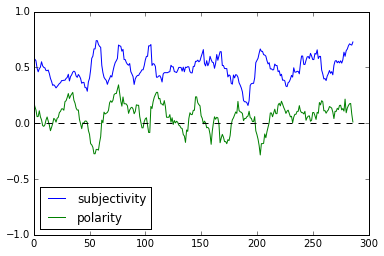

In [34]:
sentiments = [TextBlob(window).sentiment for window in sliding_window(TextBlob(text).words, size=200, step=20, merge=True)]
plot_sentiments(sentiments)

#### Now, look at all episodes at the same time

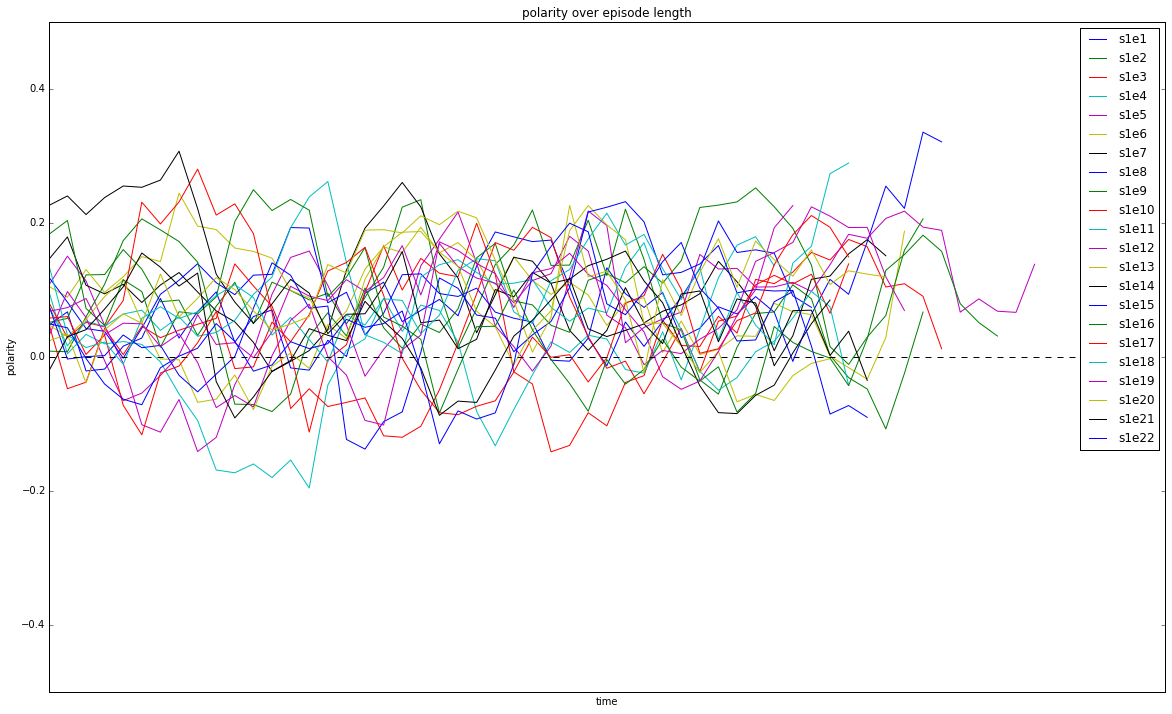

In [35]:
plt.figure(figsize=(20,12))

for episode_num, transcript in all_transcripts[1].items():
    episode_text = transcript.get_dialogue_as_one_string()
    words = TextBlob(episode_text).words
    polarities = [TextBlob(window).sentiment.polarity for window in sliding_window(words, size=400, step=100, merge=True)]
    plt.plot(polarities, label='s1e{}'.format(episode_num))

plt.legend(loc='best')
plt.axhline(0, color='black', linestyle='--')
plt.ylim(-0.5, 0.5)  #plt.ylim(-1, 1)
plt.xlabel('time')
plt.ylabel('polarity')
plt.xticks([], [])
plt.title('polarity over episode length')
plt.show()

#### Focus on 1 episode: 1 curve per character

In [36]:
transcript = all_transcripts[3][5]
sentiments = defaultdict(list)
for line_num, line in enumerate(transcript.get_dialogue_lines()):
    if line.speaker in main_characters:
        speaker = line.speaker
    else:
        speaker = 'other'
    sentiments[speaker].append((line_num, TextBlob(' '.join(line.spoken_parts)).sentiment.polarity))

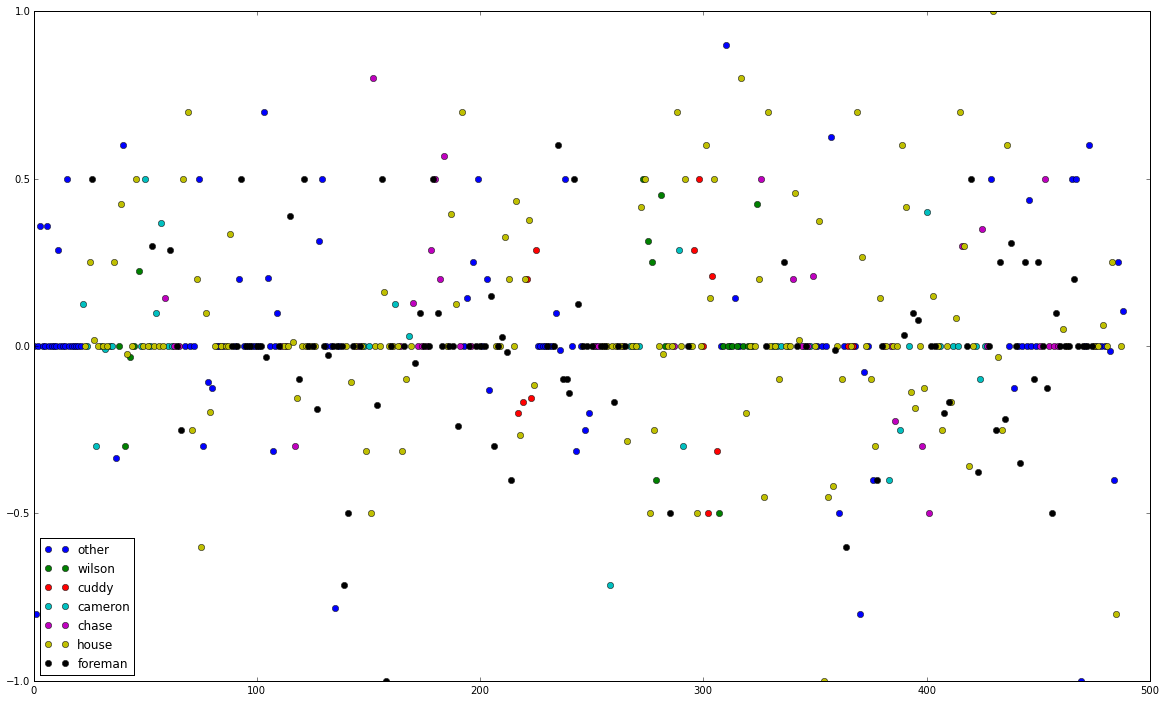

In [37]:
plt.figure(figsize=(20,12))

for character, data in sentiments.items():
    xx, yy = zip(*data)
    plt.plot(xx, yy, 'o', label=character)
plt.ylim(-1, 1)
plt.legend(loc='best')
plt.show()